In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import time # For adding a small delay between requests
import requests
from urllib.parse import quote_plus # This is crucial for URL encoding
from urllib.parse import urlencode
import sqlite3

In [3]:
# Step 3: Connect to SQLite and prepare the table
db_path = "nyc_crashes.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Read the entire 'crashes' table into a DataFrame
nyc_data_df = pd.read_sql_query("SELECT * FROM crashes", conn)

# Close connection
conn.close()

In [4]:
injury_stats = nyc_data_df['number_of_persons_injured'].describe()
fatality_stats = nyc_data_df['number_of_persons_killed'].describe()
injury_stats, fatality_stats

(count    1.980526e+06
 mean     2.972736e-01
 std      6.883178e-01
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      0.000000e+00
 max      4.300000e+01
 Name: number_of_persons_injured, dtype: float64,
 count    1.980513e+06
 mean     1.425893e-03
 std      3.976677e-02
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      0.000000e+00
 max      8.000000e+00
 Name: number_of_persons_killed, dtype: float64)

**TO DO:** Are there any other insights you can pull from the above chart?
> *  There's approximately 2M recorded accidents in the database.
> *  A vast majority of the crashes result in no injuries or deaths since the 75th percentile is 0.
> *  On average, collisions have 200x more injuries than deaths and the number of injuries between crashes vary more than the number of deaths.
> *  The collision with the worst injuries was 43, and the collision with the worst deaths is 8.

In [9]:
nyc_data_df['vehicle_type_code1'] = nyc_data_df['vehicle_type_code1'].str.upper()
vehicle_types_to_combine = ['STATION WAGON/SPORT UTILITY VEHICLE', 'SPORT UTILITY / STATION WAGON']
nyc_data_df['vehicle_type_code1'] = nyc_data_df['vehicle_type_code1'].replace(vehicle_types_to_combine, 'SUV/STATION WAGON')

# TODO: Calculate top vehicles for injuries
top_vehicles_injuries = nyc_data_df.groupby('vehicle_type_code1')['number_of_persons_injured'].sum().sort_values(ascending=False).head(10)
# TODO: Calculate top vehicles for deaths
top_vehicles_deaths = nyc_data_df.groupby('vehicle_type_code1')['number_of_persons_killed'].sum().sort_values(ascending=False).head(10)
top_vehicles_injuries, top_vehicles_deaths

(vehicle_type_code1
 SUV/STATION WAGON    179155.0
 SEDAN                174514.0
 PASSENGER VEHICLE    106857.0
 TAXI                  25041.0
 BIKE                  11593.0
 4 DR SEDAN            11309.0
 PICK-UP TRUCK          9744.0
 BUS                    9430.0
 UNKNOWN                7655.0
 VAN                    7306.0
 Name: number_of_persons_injured, dtype: float64,
 vehicle_type_code1
 SUV/STATION WAGON    751.0
 SEDAN                579.0
 PASSENGER VEHICLE    398.0
 MOTORCYCLE           257.0
 BUS                   97.0
 PICK-UP TRUCK         69.0
 TAXI                  64.0
 UNKNOWN               61.0
 BOX TRUCK             54.0
 VAN                   50.0
 Name: number_of_persons_killed, dtype: float64)

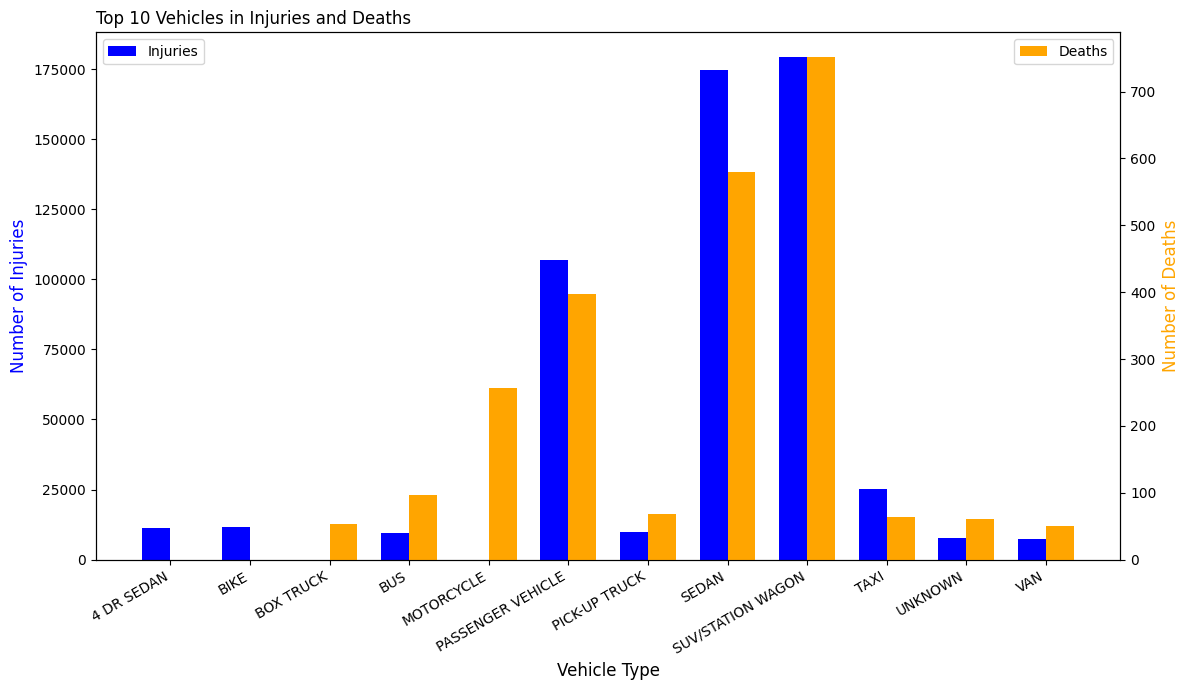

In [13]:
# TODO: Combine the data into a DataFrame
combined_data = pd.DataFrame({'Injuries': top_vehicles_injuries, 'Deaths': top_vehicles_deaths})

# Set the width of the bars
bar_width = 0.35

# Plotting the combined bar chart with bars next to each other
fig, ax1 = plt.subplots(figsize=(12, 7))

# Generate a list of indices for the x-axis
indices = np.arange(len(combined_data))

# Plotting the bars for injuries
ax1.bar(indices - bar_width/2, combined_data['Injuries'], bar_width, color='blue', label='Injuries')

# TODO: Create a secondary y-axis for deaths
ax2 = ax1.twinx()

# Plotting the bars for deaths next to injuries
ax2.bar(indices + bar_width/2, combined_data['Deaths'], bar_width, color='orange', label='Deaths')

# Adding labels and title
ax1.set_title('Top 10 Vehicles in Injuries and Deaths', fontsize=12, loc='left')
ax1.set_xlabel('Vehicle Type', fontsize=12)
ax1.set_ylabel('Number of Injuries', fontsize=12, color='blue')
# TODO: Set the label for the secondary y-axis
ax2.set_ylabel('Number of Deaths', fontsize=12, color='orange')
ax1.set_xticks(indices)
ax1.set_xticklabels(combined_data.index, rotation=30, ha='right')

# Adding legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjusting layout and displaying the combined chart
plt.tight_layout()
plt.show()

**TO DO:** What are the top 3 vehicles that were **most** involved in crashes that resulted in **injuries?**

> 1. SUV/Station Wagon
> 2. Sedan  
> 3. Passenger Vehicle  

**TO DO:** Review the top 3 vehicles that were **most** involved in crashes that resulted in **deaths.** Do these vehicles differ from those that were most involved in **injuries?**

> *   No, the top 3 vehicles most involved in crashes that results in **deaths** did not differ from those most involved in **injuries**.

**TO DO:** Why do you think those vehicles are most involved in injury-causing and death-causing crashes?

> *  

**TO DO:** Are there any recommendations you would make to the Dept. of Transportation based on the data above? Feel free to be creative.

> *  